In [ ]:
rutas = './rutas.txt'

In [ ]:
with open(rutas, 'r') as archivo:
    for linea in archivo.readlines():
        exec(linea.strip(), globals())

In [ ]:
# !pip install -r requirements

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from random import randint
import time
import sys
import warnings
warnings.filterwarnings('ignore')



In [ ]:
df_limpio = pd.read_csv(dataset_limpio)
df_limpio.head(1)

,id_orden,anio,mes,dia,dia_semana,id_usuario,volumen_total,productos_distintos_promedio,productos_distintos_total,bultos_productos,perfil_digital,segmento_unico,concentracion,nse,canal,id_producto
0,512-3775628-0,2022,7,6,2,175519,5.18752,4.1,16,2,HighUsage,4.Activos,Medio,Bajo,Kioscos/Maxikioscos,7038


In [ ]:
df_final = pd.read_csv(dataset_entrenamiento_final)
df_final.head(1)

,id_usuario,recomendaciones,perfil_digital,mes,dia,dia_semana,nse,segmento_unico,canal_Autoservicio,canal_BEBIDA,...,producto_78078,producto_78093,producto_78094,producto_78103,producto_78104,producto_78109,producto_78121,producto_78128,producto_78129,producto_78138
0,412132,5,2,6,1,2,1,0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def preprocesamiento_ant(data:pd.DataFrame, usuario:int) -> tuple | np.ndarray:
    data = data[data['id_usuario']==usuario]
    features = ['perfil_digital', 'mes', 'dia', 'dia_semana', 'nse', 'segmento_unico']
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])
    features_total = features + list(data.filter(regex='^canal_').columns)
    target = data.filter(regex='^producto_').columns
    X = data[features_total]
    y = data[target]
    if len(data) == 1:
        return y.values
    else:
        X_train = X.iloc[:-1,:]
        y_train = y.iloc[:-1,:]
        X_test = X.iloc[-1:,:]
        y_test = y.iloc[-1:,:]
        y_train = y_train.values
        y_test = y_test.values
        X_test = X_test.astype('float32')
        X_train = X_train.astype('float32')
        y_test = y_test.astype('float32')
        y_train = y_train.astype('float')
        return X_train, y_train, X_test, y_test


In [ ]:
df_final['id_usuario'].sample(5)

41321    379089
29410    188249
16838    433681
31584    435067
43873    168134
Name: id_usuario, dtype: int64

In [ ]:
a = preprocesamiento(df_final, 172254)
print(type(a), len(a))
np.where(a == 1)[1]


<class 'numpy.ndarray'> 1


array([48, 61])

In [ ]:
b = preprocesamiento(df_final, 168134)
print(type(b), len(b))
np.where(b[3] == 1)[1]




<class 'tuple'> 4


array([149, 160, 199])

In [ ]:
def modelo(data:pd.DataFrame, usuario:int, umbral:float) -> pd.DataFrame:
    comparaciones = {'usuario':'', 'umbral': '', 'y_test':[], 'productos_test':[], 'y_pred':[], 'productos_pred':[]}
    pre = preprocesamiento_ant(data, usuario)
    if isinstance(pre, tuple):
        X_train, y_train, X_test, y_test = pre
        model = Sequential([Dense(512, input_dim=X_train.shape[1], activation='swish', kernel_regularizer=l2(0.01)),
                            Dense(512, activation='swish'),
                            BatchNormalization(),
                            Dense(256, activation='swish'),
                            Dense(128, activation='swish'),
                            BatchNormalization(),
                            Dense(128, activation='swish'),
                            Dense(64, activation='swish', kernel_regularizer=l2(0.01)),
                            Dense(32, activation='swish'),
                            Dense(y_train.shape[1], activation='sigmoid')])
        model.compile(optimizer=Nadam(learning_rate=0.05), loss='binary_crossentropy')
        model.fit(X_train, y_train, epochs=30, batch_size=3, validation_data=(X_test, y_test), verbose=0, callbacks=ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-8))
        y_pred = model.predict(X_test, verbose=0)
        for i in range(len(y_test)):
            comparaciones['usuario'] = usuario
            comparaciones['umbral'] = umbral
            comparaciones['y_test'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_test'].append(len(np.where(y_test[i] ==1)[0]))
            comparaciones['y_pred'].append(np.where(y_pred[i] >= umbral)[0])
            comparaciones['productos_pred'].append(len(np.where(y_pred[i] >= umbral)[0]))
        df_comparaciones = pd.DataFrame(comparaciones)
        df_comparaciones['coincidencias'] = df_comparaciones.apply(lambda row: len(set(row['y_test']) & set(row['y_pred'])), axis=1)
        df_comparaciones = df_comparaciones[['usuario', 'umbral', 'y_test', 'productos_test', 'y_pred', 'productos_pred', 'coincidencias']]
        return df_comparaciones
    else:
        y_test = pre
        for i in range(len(y_test)):
            comparaciones['usuario'] = usuario
            comparaciones['umbral'] = umbral
            comparaciones['y_test'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_test'].append(len(np.where(y_test[i] ==1)[0]))
            comparaciones['y_pred'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_pred'].append(len(np.where(y_test[i] ==1)[0]))
        df_comparaciones = pd.DataFrame(comparaciones)
        df_comparaciones['coincidencias'] = df_comparaciones.apply(lambda row: len(set(row['y_test']) & set(row['y_pred'])), axis=1)
        df_comparaciones = df_comparaciones[['usuario', 'umbral', 'y_test', 'productos_test', 'y_pred', 'productos_pred', 'coincidencias']]
        return df_comparaciones


In [ ]:
inicio = time.time()
prueba1 = modelo(df_final, 172254, 0.5)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba1

Tiempo: 0.02197098731994629


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,172254,0.5,"[48, 61]",2,"[48, 61]",2,2


In [ ]:
inicio = time.time()
prueba2 = modelo(df_final, 168134, 0.3)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba2


Tiempo: 11.506924152374268


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,168134,0.3,"[149, 160, 199]",3,"[70, 149]",2,1


In [ ]:
usuarios  = df_final['id_usuario'].sample(20)


In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
for usuario in usuarios:
    for umbral in [0.3, 0.4, 0.5, 0.6]:
        df_prueba = modelo(df_final, usuario, umbral)
        df_pruebas = pd.concat([df_pruebas, df_prueba])
final = time.time()
print(f'Tiempo: {final - inicio}')
df_pruebas

Tiempo: 811.8207528591156


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,331490,0.3,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 101, 116, 154, 196, 198, 293]",7,6
0,331490,0.4,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6
0,331490,0.5,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6
0,331490,0.6,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6
0,447520,0.3,"[349, 353, 460]",3,"[261, 262, 461]",3,0
...,...,...,...,...,...,...,...
0,430210,0.6,"[26, 41, 91, 196, 198, 313]",6,"[196, 198, 313]",3,3
0,397435,0.3,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[6, 23, 39, 91, 100, 131, 132, 135, 169, 196, ...",16,6
0,397435,0.4,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[23, 39, 91, 131, 169, 196, 211, 313, 316]",9,3
0,397435,0.5,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[39, 91, 196, 211, 313]",5,3


In [ ]:
df_pruebas.to_excel(comparaciones + '/pruebas_nn.xlsx', index=False)

In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.head()

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,0.3,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 101, 116, 154, 196, 198, 293]",7,6,0.992453,0.857143,0.666667,0.75,0.007547
0,331490,0.4,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6,0.994340,1.000000,0.666667,0.80,0.005660
0,331490,0.5,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6,0.994340,1.000000,0.666667,0.80,0.005660
0,331490,0.6,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6,0.994340,1.000000,0.666667,0.80,0.005660
0,447520,0.3,"[349, 353, 460]",3,"[261, 262, 461]",3,0,0.988679,0.000000,0.000000,NaN,0.011321


In [ ]:
df_pruebas.to_excel(comparaciones + '/pruebas_nn.xlsx', index=False)

###Contexto

El objetivo es desarrollar un sistema predictivo para integrar en una aplicación, utilizando datos de transacciones y atributos de clientes para predecir los productos de la próxima compra. Las predicciones abarcan 530 variables objetivo binarias.

###Implementación del Clasificador

Se optó por un clasificador en lugar de un sistema de recomendación basado en similitud con embeddings debido a la falta de personalización de estos últimos. Los embeddings tienden a generalizar y no capturan las particularidades de cada cliente. Para el clasificador, se probaron diversos modelos, incluyendo Random Forest, XGBoost y Redes Neuronales, ajustando múltiples hiperparámetros. Después de evaluar más de 1400 combinaciones, se seleccionó la mejor red neuronal. Para mejorar la personalización, se aprovechó el efecto de overfitting, permitiendo así capturar mejor las características específicas de cada cliente.

###Limitaciones de los Embeddings

No se utilizaron embeddings principalmente por su tendencia a generalizar, lo que resulta en una pérdida de personalización. Además, el costo computacional de generar embeddings para todos los usuarios y productos es elevado. Generar embeddings para un solo usuario con pocas transacciones no tiene sentido, ya que no proporciona buenas predicciones debido a la falta de datos suficientes para capturar patrones individuales.

###Desempeño del Modelo

El modelo muestra buen desempeño con clientes que tienen un mayor número de transacciones, obteniendo buenas métricas de precisión, recall, f1 y hamming loss. Se da prioridad a la precisión, ya que el enfoque está centrado en el usuario. Al ajustar los umbrales, se observó que una disminución en el umbral reduce la precisión y aumenta el recall, y viceversa. Sin embargo, con clientes que tienen pocas transacciones (una o dos), el modelo no puede entrenarse de manera robusta, ya que estos clientes pueden mostrar comportamientos de compra variables entre transacciones, dificultando la identificación de patrones consistentes.

###Abordaje del Problema

Para abordar la problemática con clientes de pocas transacciones, se decidió utilizar inferencia estadística en lugar de embeddings. Esta decisión se tomó debido a dos razones principales: el alto costo computacional de generar embeddings para todos los usuarios y productos, y la ineficacia de generar embeddings para usuarios con pocas transacciones. La inferencia estadística se utiliza para complementar las predicciones, permitiendo una mejor personalización sin incurrir en los altos costos computacionales asociados con los embeddings. Esto asegura que incluso con poca información, se pueden realizar predicciones más precisas y personalizadas.

##Cantidad de recomendaciones

El criterio utilizado para decidir la cantidad de productos recomendados va a ser tomar el número entero superior al promedio de productos distintos por cada orden de cada usuario. En algunos casos va a bajar precision y va a subir recall, pero, a priori, parece algo bastante equilibrado y la tendencia es recomendar más productos. Encontrar el equilibrio en este tipo de sistemas puede ser complejo, ya que si tenemos un recall muy alto se pueden recomendar productos que no son del interés del usuario y si nos enfocamos en precision se van a recomendar, en líneas generales, menos productos. Con el umbral modificamos ambas métricas. Recomendar productos de más puede ser, en algunos casos, beneficioso para la empresa, pero puede no gustarle al usuario. En este caso, el problema se plantea desde el usuario, por lo que vamos a considerar precision como métrica más relevante. En los casos en los que el modelo no llega a dar la cantidad de recomendaciones estimadas, se completará con inferencia estadística, contemplando los productos más vendidos. La hipótesis es que este enfoque no debería afectar la satisfacción del usuario con respecto a la aplicación y a la vez puede ser beneficioso para la empresa.

In [ ]:
df_final.head(1)

,id_orden,id_usuario,perfil_digital,mes,dia,dia_semana,nse,segmento_unico,canal_Autoservicio,canal_BEBIDA,...,producto_78078,producto_78093,producto_78094,producto_78103,producto_78104,producto_78109,producto_78121,producto_78128,producto_78129,producto_78138
0,101-21757542-0,412132,2,6,1,2,1,0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_limpio.head(1)

,id_orden,anio,mes,dia,dia_semana,id_usuario,volumen_total,productos_distintos_promedio,productos_distintos_total,bultos_productos,perfil_digital,segmento_unico,concentracion,nse,canal,id_producto
0,512-3775628-0,2022,7,6,2,175519,5.18752,4.1,16,2,HighUsage,4.Activos,Medio,Bajo,Kioscos/Maxikioscos,7038


In [ ]:
df_limpio[df_limpio['id_usuario'].isin([22204, 22247, 175519, 677161, 412132])].drop_duplicates(subset='id_usuario', keep='first')


,id_orden,anio,mes,dia,dia_semana,id_usuario,volumen_total,productos_distintos_promedio,productos_distintos_total,bultos_productos,perfil_digital,segmento_unico,concentracion,nse,canal,id_producto
0,512-3775628-0,2022,7,6,2,175519,5.18752,4.1000,16,2,HighUsage,4.Activos,Medio,Bajo,Kioscos/Maxikioscos,7038
80074,512-3993098-0,2022,8,23,1,22247,1.83070,4.0000,11,3,MediumUsage,1.Inactivos,Alto,Medio,Tradicional,7651
250716,512-3976753-0,2022,8,19,4,677161,6.30900,6.5000,10,4,MediumUsage,2.Masivos,Medio,Medio,COMIDA,16667
253375,102-39130554-0,2022,7,12,1,22204,0.12000,2.0000,2,1,MediumUsage,4.Activos,Alto,Medio,COMIDA,813
274521,101-21765787-0,2022,6,4,5,412132,29.03432,4.9231,21,5,MediumUsage,S/D,Medio,Bajo,Instituciones,1483


In [ ]:
df_limpio.groupby('id_usuario')['productos_distintos_promedio'].first()

id_usuario
22204      2.0000
22247      4.0000
22456     12.4444
22477      3.3889
22639      8.0000
           ...   
676899     5.5000
676938     5.1765
677161     6.5000
677195     8.5385
677317     3.8889
Name: productos_distintos_promedio, Length: 4535, dtype: float64

In [ ]:
productos_distintos_dict = df_limpio.drop_duplicates(subset=['id_usuario']).set_index('id_usuario')['productos_distintos_promedio'].to_dict()

In [ ]:
df_final['promedio'] = df_final['id_usuario'].map(productos_distintos_dict)



In [ ]:
df_final['promedio'].isna().sum()

0

In [ ]:
df_final.head(1)

,id_orden,id_usuario,perfil_digital,mes,dia,dia_semana,nse,segmento_unico,canal_Autoservicio,canal_BEBIDA,...,producto_78093,producto_78094,producto_78103,producto_78104,producto_78109,producto_78121,producto_78128,producto_78129,producto_78138,promedio
0,101-21757542-0,412132,2,6,1,2,1,0,False,False,...,0,0,0,0,0,0,0,0,0,4.9231


In [ ]:
df_final[df_final['id_usuario'].isin([22204, 22247, 175519, 677161, 412132])].drop_duplicates(subset='id_usuario', keep='first')

,id_orden,id_usuario,perfil_digital,mes,dia,dia_semana,nse,segmento_unico,canal_Autoservicio,canal_BEBIDA,...,producto_78094,producto_78103,producto_78104,producto_78109,producto_78121,producto_78128,producto_78129,producto_78138,promedio,recomendaciones
0,101-21757542-0,412132,2,6,1,2,1,0,False,False,...,0,0,0,0,0,0,0,0,4.9231,5
974,102-39080265-0,22204,2,6,28,1,2,4,False,False,...,0,0,0,0,0,0,0,0,2.0000,2
2849,512-3636511-0,175519,3,6,1,2,1,4,False,False,...,0,0,0,0,0,0,0,0,4.1000,5
4060,512-3648345-0,677161,2,6,3,4,2,2,False,False,...,0,0,0,0,0,0,0,0,6.5000,7
5316,512-3660370-0,22247,2,6,7,1,2,1,False,False,...,0,0,0,0,0,0,0,0,4.0000,4


In [ ]:
df_final['recomendaciones'] = df_final['promedio'].apply(lambda x: int(np.ceil(x))).astype(int)

In [ ]:
df_final.drop(columns=['promedio', 'id_orden'], inplace=True)

In [ ]:
df_final.head(1)

,id_usuario,perfil_digital,mes,dia,dia_semana,nse,segmento_unico,canal_Autoservicio,canal_BEBIDA,canal_Bar/Restaurant,...,producto_78093,producto_78094,producto_78103,producto_78104,producto_78109,producto_78121,producto_78128,producto_78129,producto_78138,recomendaciones
0,412132,2,6,1,2,1,0,False,False,False,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
columnas = list(df_final.columns)
columnas.insert(1, columnas.pop(columnas.index('recomendaciones')))
df_final = df_final[columnas]

In [ ]:
df_final.head(1)

,id_usuario,recomendaciones,perfil_digital,mes,dia,dia_semana,nse,segmento_unico,canal_Autoservicio,canal_BEBIDA,...,producto_78078,producto_78093,producto_78094,producto_78103,producto_78104,producto_78109,producto_78121,producto_78128,producto_78129,producto_78138
0,412132,5,2,6,1,2,1,0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_final.to_csv(dataset_entrenamiento_final, index=False)

##Redefinición de funciones para ajustar el número de predicciones e incluir inferencia estadística

In [ ]:
productos = []
for producto in df_final.filter(regex='^producto_').columns:
    productos.append({producto:df_final[producto].sum()})


In [ ]:
productos.sort(key=lambda x: x[list(x.keys())[0]], reverse=True)

In [ ]:
productos_prediccion = []
for i in range(10):
    productos_prediccion.append(list(productos[i].keys())[0])


In [ ]:
productos_prediccion

['producto_7038',
 'producto_19088',
 'producto_7651',
 'producto_24880',
 'producto_19341',
 'producto_19086',
 'producto_7026',
 'producto_23902',
 'producto_16668',
 'producto_16667']

In [ ]:
def preprocesamiento(data:pd.DataFrame, usuario:int) -> tuple | np.ndarray:
    data = data[data['id_usuario']==usuario]
    recomendaciones = int(data['recomendaciones'][data['id_usuario']==usuario].unique())
    productos = []
    for producto in df_final.filter(regex='^producto_').columns:
        productos.append({producto:df_final[producto].sum()})
    productos.sort(key=lambda x: x[list(x.keys())[0]], reverse=True)
    productos_prediccion = []
    for i in range(10):
        productos_prediccion.append(list(productos[i].keys())[0])
    productos_codificados = []
    for i in range(len(df_final.columns[-530:])):
        productos_codificados.append({df_final.columns[-530:][i]:i})
    productos_frecuencias = []
    for producto in productos_codificados:
        for productop in productos_prediccion:
            if productop in producto.keys():
                productos_frecuencias.append(producto[productop])
    features = ['perfil_digital', 'mes', 'dia', 'dia_semana', 'nse', 'segmento_unico']
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])
    features_total = features + list(data.filter(regex='^canal_').columns)
    target = data.filter(regex='^producto_').columns
    X = data[features_total]
    y = data[target]
    if len(data) == 1:
        return y.values
    else:
        X_train = X.iloc[:-1,:]
        y_train = y.iloc[:-1,:]
        X_test = X.iloc[-1:,:]
        y_test = y.iloc[-1:,:]
        y_train = y_train.values
        y_test = y_test.values
        X_test = X_test.astype('float32')
        X_train = X_train.astype('float32')
        y_test = y_test.astype('float32')
        y_train = y_train.astype('float')
        return X_train, y_train, X_test, y_test, recomendaciones, productos_frecuencias


In [ ]:
a = preprocesamiento(df_final, 172254)
print(type(a), len(a))
np.where(a == 1)[1]


<class 'numpy.ndarray'> 1


array([48, 61])

In [ ]:
b = preprocesamiento(df_final, 168134)
print(type(b), len(b))
np.where(b[3] == 1)[1]




<class 'tuple'> 6


array([149, 160, 199])

In [ ]:
pre = preprocesamiento(df_final, 331490)
if isinstance(pre, tuple):
    X_train, y_train, X_test, y_test = pre[:4]
    recomendaciones = pre[4]
    productos_frecuencia = pre[5]
    model = Sequential([Dense(512, input_dim=X_train.shape[1], activation='swish', kernel_regularizer=l2(0.01)),
                        Dense(512, activation='swish'),
                        BatchNormalization(),
                        Dense(256, activation='swish'),
                        Dense(128, activation='swish'),
                        BatchNormalization(),
                        Dense(128, activation='swish'),
                        Dense(64, activation='swish', kernel_regularizer=l2(0.01)),
                        Dense(32, activation='swish'),
                        Dense(y_train.shape[1], activation='sigmoid')])
    model.compile(optimizer=Nadam(learning_rate=0.05), loss='binary_crossentropy')
    model.fit(X_train, y_train, epochs=30, batch_size=3, validation_data=(X_test, y_test), verbose=0, callbacks=ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-8))
    y_pred = model.predict(X_test, verbose=0)

##Prueba contemplando precision y agregando productos por inferencia estadística

In [ ]:
print(f'y_test: {np.where(y_test ==1)[1]}\ny_pred: {np.where(y_pred >= 0.5)[1]}\nrecomendaciones: {recomendaciones}')

y_test: [  3  48 116 154 181 196 198 293 465]
y_pred: [ 48 116 154 196 198 293]
recomendaciones: 9


In [ ]:
productos_frecuencia

[44, 48, 62, 116, 117, 147, 149, 160, 261, 293]

In [ ]:
prediccion = np.where(y_pred >= 0.5)[1]
productos_recomendacion = []
for producto in productos_frecuencia:
    if producto not in prediccion:
        productos_recomendacion.append(producto)
for i in range(len(productos_recomendacion)):
    if len(prediccion) < recomendaciones:
        prediccion = np.append(prediccion, productos_recomendacion[i])
    else:
        break


In [ ]:
print(f'y_test: {np.where(y_test ==1)[1]}\ny_pred: {prediccion}\nrecomendaciones: {recomendaciones}')

y_test: [  3  48 116 154 181 196 198 293 465]
y_pred: [ 48 116 154 196 198 293  44  62 117]
recomendaciones: 9


##Prueba devolviendo los n productos (recomendaciones) que el modelo estima que tienen mayores probabilidades de ser comprados

In [ ]:
y_pred

array([[1.1473207e-03, 1.6833667e-01, 1.1616256e-03, 4.4474226e-01,
        1.3358829e-03, 9.6529874e-04, 1.1333509e-03, 1.7395101e-03,
        1.4797379e-03, 1.3471737e-03, 9.7292353e-04, 1.4929681e-03,
        1.4502787e-03, 1.2119764e-03, 1.2368007e-03, 1.4063925e-03,
        1.6543800e-03, 1.1366577e-03, 1.8479563e-03, 1.2458457e-03,
        1.9754355e-03, 1.0247896e-03, 1.1719526e-03, 1.5318167e-03,
        1.6109464e-03, 1.6095557e-03, 1.3250875e-03, 1.1951791e-03,
        9.8667026e-04, 1.1287369e-03, 1.1896369e-03, 1.1427156e-03,
        1.0981493e-03, 1.4375801e-03, 1.1154896e-03, 1.4464587e-03,
        1.0386895e-03, 1.1114347e-03, 1.4706138e-03, 1.6113404e-03,
        1.0470271e-03, 1.7758098e-01, 1.1453879e-03, 1.1041636e-03,
        1.0270890e-03, 1.9244665e-03, 1.1597378e-03, 1.4757842e-03,
        8.8517785e-01, 1.7131428e-03, 1.6017579e-03, 1.1291272e-03,
        1.5255772e-03, 1.3173600e-03, 2.1477074e-03, 2.3708900e-03,
        1.7755775e-03, 1.1984749e-03, 1.0848552e

In [ ]:
prediccion = np.argsort(y_pred[0])[-recomendaciones:][::-1]

In [ ]:
prediccion.sort()

In [ ]:
print(f'y_test: {np.where(y_test ==1)[1]}\ny_pred: {prediccion}\nrecomendaciones: {recomendaciones}')

y_test: [  3  48 116 154 181 196 198 293 465]
y_pred: [  3  48 101 109 116 154 196 198 293]
recomendaciones: 9


##Pruebas generales

###Inferencia estadística

In [ ]:
def modelo_estadistica(data:pd.DataFrame, usuario:int, umbral:float) -> pd.DataFrame:
    comparaciones = {'usuario':'', 'umbral': '', 'y_test':[], 'productos_test':[], 'y_pred':[], 'productos_pred':[]}
    pre = preprocesamiento(data, usuario)
    if isinstance(pre, tuple):
        X_train, y_train, X_test, y_test = pre[:4]
        recomendaciones = pre[4]
        productos_frecuencia= pre[5]
        model = Sequential([Dense(512, input_dim=X_train.shape[1], activation='swish', kernel_regularizer=l2(0.01)),
                            Dense(512, activation='swish'),
                            BatchNormalization(),
                            Dense(256, activation='swish'),
                            Dense(128, activation='swish'),
                            BatchNormalization(),
                            Dense(128, activation='swish'),
                            Dense(64, activation='swish', kernel_regularizer=l2(0.01)),
                            Dense(32, activation='swish'),
                            Dense(y_train.shape[1], activation='sigmoid')])
        model.compile(optimizer=Nadam(learning_rate=0.05), loss='binary_crossentropy')
        model.fit(X_train, y_train, epochs=30, batch_size=3, validation_data=(X_test, y_test), verbose=0, callbacks=ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-8))
        y_pred = model.predict(X_test, verbose=0)
        prediccion = np.where(y_pred >= umbral)[1]
        productos_recomendacion = []
        for producto in productos_frecuencia:
            if producto not in prediccion:
                productos_recomendacion.append(producto)
        for i in range(len(productos_recomendacion)):
            if len(prediccion) < recomendaciones:
                prediccion = np.append(prediccion, productos_recomendacion[i])
            else:
                break
        prediccion.sort()
        for i in range(len(y_test)):
            comparaciones['usuario'] = usuario
            comparaciones['umbral'] = umbral
            comparaciones['y_test'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_test'].append(len(np.where(y_test[i] ==1)[0]))
            comparaciones['y_pred'].append(prediccion)
            comparaciones['productos_pred'].append(len(prediccion))
        df_comparaciones = pd.DataFrame(comparaciones)
        df_comparaciones['coincidencias'] = df_comparaciones.apply(lambda row: len(set(row['y_test']) & set(row['y_pred'])), axis=1)
        df_comparaciones = df_comparaciones[['usuario', 'umbral', 'y_test', 'productos_test', 'y_pred', 'productos_pred', 'coincidencias']]
        return df_comparaciones
    else:
        y_test = pre
        for i in range(len(y_test)):
            comparaciones['usuario'] = usuario
            comparaciones['umbral'] = umbral
            comparaciones['y_test'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_test'].append(len(np.where(y_test[i] ==1)[0]))
            comparaciones['y_pred'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_pred'].append(len(np.where(y_test[i] ==1)[0]))
        df_comparaciones = pd.DataFrame(comparaciones)
        df_comparaciones['coincidencias'] = df_comparaciones.apply(lambda row: len(set(row['y_test']) & set(row['y_pred'])), axis=1)
        df_comparaciones = df_comparaciones[['usuario', 'umbral', 'y_test', 'productos_test', 'y_pred', 'productos_pred', 'coincidencias']]
        return df_comparaciones


In [ ]:
inicio = time.time()
prueba1 = modelo_estadistica(df_final, 172254, 0.5)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba1

Tiempo: 0.5421829223632812


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,172254,0.5,"[48, 61]",2,"[48, 61]",2,2


In [ ]:
inicio = time.time()
prueba2 = modelo_estadistica(df_final, 168134, 0.3)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba2


Tiempo: 10.087156534194946


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,168134,0.3,"[149, 160, 199]",3,"[44, 48, 70, 149]",4,1


###Regresión logística

In [ ]:
def modelo_probabilidades(data:pd.DataFrame, usuario:int, umbral:float) -> pd.DataFrame:
    comparaciones = {'usuario':'', 'umbral': '', 'y_test':[], 'productos_test':[], 'y_pred':[], 'productos_pred':[]}
    pre = preprocesamiento(data, usuario)
    if isinstance(pre, tuple):
        X_train, y_train, X_test, y_test = pre[:4]
        recomendaciones = pre[4]
        productos_frecuencia= pre[5]
        model = Sequential([Dense(512, input_dim=X_train.shape[1], activation='swish', kernel_regularizer=l2(0.01)),
                            Dense(512, activation='swish'),
                            BatchNormalization(),
                            Dense(256, activation='swish'),
                            Dense(128, activation='swish'),
                            BatchNormalization(),
                            Dense(128, activation='swish'),
                            Dense(64, activation='swish', kernel_regularizer=l2(0.01)),
                            Dense(32, activation='swish'),
                            Dense(y_train.shape[1], activation='sigmoid')])
        model.compile(optimizer=Nadam(learning_rate=0.05), loss='binary_crossentropy')
        model.fit(X_train, y_train, epochs=30, batch_size=3, validation_data=(X_test, y_test), verbose=0, callbacks=ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-8))
        y_pred = model.predict(X_test, verbose=0)
        prediccion = np.argsort(y_pred[0])[-recomendaciones:][::-1]
        prediccion.sort()
        for i in range(len(y_test)):
            comparaciones['usuario'] = usuario
            comparaciones['umbral'] = umbral
            comparaciones['y_test'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_test'].append(len(np.where(y_test[i] ==1)[0]))
            comparaciones['y_pred'].append(prediccion)
            comparaciones['productos_pred'].append(len(prediccion))
        df_comparaciones = pd.DataFrame(comparaciones)
        df_comparaciones['coincidencias'] = df_comparaciones.apply(lambda row: len(set(row['y_test']) & set(row['y_pred'])), axis=1)
        df_comparaciones = df_comparaciones[['usuario', 'umbral', 'y_test', 'productos_test', 'y_pred', 'productos_pred', 'coincidencias']]
        return df_comparaciones
    else:
        y_test = pre
        for i in range(len(y_test)):
            comparaciones['usuario'] = usuario
            comparaciones['umbral'] = umbral
            comparaciones['y_test'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_test'].append(len(np.where(y_test[i] ==1)[0]))
            comparaciones['y_pred'].append(np.where(y_test[i] ==1)[0])
            comparaciones['productos_pred'].append(len(np.where(y_test[i] ==1)[0]))
        df_comparaciones = pd.DataFrame(comparaciones)
        df_comparaciones['coincidencias'] = df_comparaciones.apply(lambda row: len(set(row['y_test']) & set(row['y_pred'])), axis=1)
        df_comparaciones = df_comparaciones[['usuario', 'umbral', 'y_test', 'productos_test', 'y_pred', 'productos_pred', 'coincidencias']]
        return df_comparaciones


In [ ]:
inicio = time.time()
prueba1 = modelo_probabilidades(df_final, 172254, -1)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba1

Tiempo: 0.1266648769378662


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,172254,-1,"[48, 61]",2,"[48, 61]",2,2


In [ ]:
inicio = time.time()
prueba2 = modelo_probabilidades(df_final, 397435	, -1)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba2


Tiempo: 8.622086763381958


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,397435,-1,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[7, 23, 39, 58, 69, 91, 100, 131, 132, 135, 18...",16,6


In [ ]:
inicio = time.time()
prueba2 = modelo_probabilidades(df_final, 168134, -1)
final = time.time()
print(f'Tiempo: {final - inicio}')
prueba2

Tiempo: 9.822119235992432


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,168134,-1,"[149, 160, 199]",3,"[31, 46, 70, 149]",4,1


In [ ]:
usuarios  = [331490, 447520, 445654, 451882, 74764, 335995, 417866, 408145, 392364, 185697, 435069, 422935, 433942, 418056, 417100, 390305, 306713, 427863, 430210, 397435]



In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
prueba = 0
for usuario in usuarios:
    inicio_p = time.time()
    df_prueba = modelo_probabilidades(df_final, usuario, -1)
    df_pruebas = pd.concat([df_pruebas, df_prueba])
    for umbral in [0.3, 0.4, 0.5, 0.6]:
        df_prueba = modelo_estadistica(df_final, usuario, umbral)
        df_pruebas = pd.concat([df_pruebas, df_prueba])
    df_pruebas.to_excel(comparaciones + '/pruebas_nn_final.xlsx', index=False)
    prueba += 1
    final_p = time.time()
    sys.stdout.write(f'\rPrueba número: {prueba}   Tiempo: {round(final_p-inicio_p, 2)} segundos')
    sys.stdout.flush()
final = time.time()
print(f'Tiempo total: {final - inicio}')
df_pruebas

Prueba número: 20   Tiempo: 37.7 segundosTiempo total: 964.501211643219


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,331490,-1.0,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[3, 48, 101, 109, 116, 154, 196, 198, 293]",9,7
0,331490,0.3,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[44, 48, 62, 116, 117, 154, 196, 198, 293]",9,6
0,331490,0.4,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[41, 44, 48, 62, 101, 116, 154, 196, 198]",9,5
0,331490,0.5,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[3, 44, 48, 62, 116, 154, 196, 198, 293]",9,7
0,331490,0.6,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[44, 48, 62, 116, 117, 154, 196, 198, 293]",9,6
...,...,...,...,...,...,...,...
0,397435,-1.0,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[6, 8, 23, 26, 39, 91, 100, 131, 132, 169, 196...",16,6
0,397435,0.3,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[6, 7, 8, 23, 26, 39, 44, 48, 91, 131, 132, 13...",16,8
0,397435,0.4,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[9, 23, 39, 55, 57, 80, 91, 94, 100, 132, 133,...",19,5
0,397435,0.5,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[6, 8, 23, 39, 44, 48, 62, 91, 116, 117, 131, ...",16,4


In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.to_excel(comparaciones + '/pruebas_nn_final.xlsx', index=False)

In [ ]:
df_1 = pd.read_excel(comparaciones + '/pruebas_nn_final.xlsx')
df_2 = pd.read_excel(comparaciones + '/pruebas_nn.xlsx')

In [ ]:
df_1[df_1['usuario']==usuarios[0]]

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,-1.0,[ 3 48 116 154 181 196 198 293 465],9,[ 3 48 101 109 116 154 196 198 293],9,7,0.992453,0.777778,0.777778,0.777778,0.007547
1,331490,0.3,[ 3 48 116 154 181 196 198 293 465],9,[ 44 48 62 116 117 154 196 198 293],9,6,0.988679,0.666667,0.666667,0.666667,0.011321
2,331490,0.4,[ 3 48 116 154 181 196 198 293 465],9,[ 41 44 48 62 101 116 154 196 198],9,5,0.984906,0.555556,0.555556,0.555556,0.015094
3,331490,0.5,[ 3 48 116 154 181 196 198 293 465],9,[ 3 44 48 62 116 154 196 198 293],9,7,0.992453,0.777778,0.777778,0.777778,0.007547
4,331490,0.6,[ 3 48 116 154 181 196 198 293 465],9,[ 44 48 62 116 117 154 196 198 293],9,6,0.988679,0.666667,0.666667,0.666667,0.011321


In [ ]:
df_2.head(1)

,Unnamed: 0,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,0.3,[ 3 48 116 154 181 196 198 293 465],9,[ 48 101 116 154 196 198 293],7,6,0.992453,0.857143,0.666667,0.75,0.007547


In [ ]:
df_2.rename(columns={'Unnamed: 0':'usuario'}, inplace=True)

In [ ]:
df_2[df_2['usuario']==usuarios[0]]

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,0.3,[ 3 48 116 154 181 196 198 293 465],9,[ 48 101 116 154 196 198 293],7,6,0.992453,0.857143,0.666667,0.75,0.007547
1,331490,0.4,[ 3 48 116 154 181 196 198 293 465],9,[ 48 116 154 196 198 293],6,6,0.994340,1.000000,0.666667,0.80,0.005660
2,331490,0.5,[ 3 48 116 154 181 196 198 293 465],9,[ 48 116 154 196 198 293],6,6,0.994340,1.000000,0.666667,0.80,0.005660
3,331490,0.6,[ 3 48 116 154 181 196 198 293 465],9,[ 48 116 154 196 198 293],6,6,0.994340,1.000000,0.666667,0.80,0.005660


In [ ]:
df_general = pd.concat([df_1, df_2])


In [ ]:
df_general.to_excel(comparaciones + '/pruebas_nn_general.xlsx', index=False)

In [ ]:
df_general.head(1)

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,-1.0,[ 3 48 116 154 181 196 198 293 465],9,[ 3 48 101 109 116 154 196 198 293],9,7,0.992453,0.777778,0.777778,0.777778,0.007547


In [ ]:
df_general[df_general['usuario']==usuarios[0]]

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,-1.0,[ 3 48 116 154 181 196 198 293 465],9,[ 3 48 101 109 116 154 196 198 293],9,7,0.992453,0.777778,0.777778,0.777778,0.007547
1,331490,0.3,[ 3 48 116 154 181 196 198 293 465],9,[ 44 48 62 116 117 154 196 198 293],9,6,0.988679,0.666667,0.666667,0.666667,0.011321
2,331490,0.4,[ 3 48 116 154 181 196 198 293 465],9,[ 41 44 48 62 101 116 154 196 198],9,5,0.984906,0.555556,0.555556,0.555556,0.015094
3,331490,0.5,[ 3 48 116 154 181 196 198 293 465],9,[ 3 44 48 62 116 154 196 198 293],9,7,0.992453,0.777778,0.777778,0.777778,0.007547
4,331490,0.6,[ 3 48 116 154 181 196 198 293 465],9,[ 44 48 62 116 117 154 196 198 293],9,6,0.988679,0.666667,0.666667,0.666667,0.011321
0,331490,0.3,[ 3 48 116 154 181 196 198 293 465],9,[ 48 101 116 154 196 198 293],7,6,0.992453,0.857143,0.666667,0.750000,0.007547
1,331490,0.4,[ 3 48 116 154 181 196 198 293 465],9,[ 48 116 154 196 198 293],6,6,0.994340,1.000000,0.666667,0.800000,0.005660
2,331490,0.5,[ 3 48 116 154 181 196 198 293 465],9,[ 48 116 154 196 198 293],6,6,0.994340,1.000000,0.666667,0.800000,0.005660
3,331490,0.6,[ 3 48 116 154 181 196 198 293 465],9,[ 48 116 154 196 198 293],6,6,0.994340,1.000000,0.666667,0.800000,0.005660


In [ ]:
df_general[df_general['usuario']==usuarios[1]]

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
5,447520,-1.0,[349 353 460],3,[ 48 119 261 262 461],5,0,0.984906,0.000000,0.000000,NaN,0.015094
6,447520,0.3,[349 353 460],3,[ 31 44 119 261 262],5,0,0.984906,0.000000,0.000000,NaN,0.015094
7,447520,0.4,[349 353 460],3,[ 44 48 62 261 262],5,0,0.984906,0.000000,0.000000,NaN,0.015094
8,447520,0.5,[349 353 460],3,[ 44 119 261 262 461],5,0,0.984906,0.000000,0.000000,NaN,0.015094
9,447520,0.6,[349 353 460],3,[ 48 261 262 296 386 460 489],7,1,0.984906,0.142857,0.333333,0.2,0.015094
4,447520,0.3,[349 353 460],3,[261 262 461],3,0,0.988679,0.000000,0.000000,NaN,0.011321
5,447520,0.4,[349 353 460],3,[ 31 48 62 261 262],5,0,0.984906,0.000000,0.000000,NaN,0.015094
6,447520,0.5,[349 353 460],3,[ 48 261 262],3,0,0.988679,0.000000,0.000000,NaN,0.011321
7,447520,0.6,[349 353 460],3,[ 48 261 262],3,0,0.988679,0.000000,0.000000,NaN,0.011321


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[0]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,331490,9,9,7,0.992453,0.777778,0.777778,0.007547
1,331490,9,9,6,0.988679,0.666667,0.666667,0.011321
2,331490,9,9,5,0.984906,0.555556,0.555556,0.015094
3,331490,9,9,7,0.992453,0.777778,0.777778,0.007547
4,331490,9,9,6,0.988679,0.666667,0.666667,0.011321
5,331490,9,7,6,0.992453,0.857143,0.666667,0.007547
6,331490,9,6,6,0.994340,1.000000,0.666667,0.005660
7,331490,9,6,6,0.994340,1.000000,0.666667,0.005660
8,331490,9,6,6,0.994340,1.000000,0.666667,0.005660


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[1]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,447520,3,5,0,0.984906,0.000000,0.000000,0.015094
1,447520,3,5,0,0.984906,0.000000,0.000000,0.015094
2,447520,3,5,0,0.984906,0.000000,0.000000,0.015094
3,447520,3,5,0,0.984906,0.000000,0.000000,0.015094
4,447520,3,7,1,0.984906,0.142857,0.333333,0.015094
5,447520,3,3,0,0.988679,0.000000,0.000000,0.011321
6,447520,3,5,0,0.984906,0.000000,0.000000,0.015094
7,447520,3,3,0,0.988679,0.000000,0.000000,0.011321
8,447520,3,3,0,0.988679,0.000000,0.000000,0.011321


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[2]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,445654,10,6,3,0.981132,0.500000,0.3,0.018868
1,445654,10,6,1,0.973585,0.166667,0.1,0.026415
2,445654,10,6,1,0.973585,0.166667,0.1,0.026415
3,445654,10,6,1,0.973585,0.166667,0.1,0.026415
4,445654,10,6,2,0.977358,0.333333,0.2,0.022642
5,445654,10,2,1,0.981132,0.500000,0.1,0.018868
6,445654,10,0,0,0.981132,NaN,0.0,0.018868
7,445654,10,3,2,0.983019,0.666667,0.2,0.016981
8,445654,10,0,0,0.981132,NaN,0.0,0.018868


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[3]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,451882,4,3,2,0.99434,0.666667,0.50,0.00566
1,451882,4,3,2,0.99434,0.666667,0.50,0.00566
2,451882,4,3,2,0.99434,0.666667,0.50,0.00566
3,451882,4,3,2,0.99434,0.666667,0.50,0.00566
4,451882,4,3,2,0.99434,0.666667,0.50,0.00566
5,451882,4,1,1,0.99434,1.000000,0.25,0.00566
6,451882,4,1,1,0.99434,1.000000,0.25,0.00566
7,451882,4,1,1,0.99434,1.000000,0.25,0.00566
8,451882,4,1,1,0.99434,1.000000,0.25,0.00566


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[4]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,74764,6,11,2,0.975472,0.181818,0.333333,0.024528
1,74764,6,13,3,0.975472,0.230769,0.500000,0.024528
2,74764,6,11,2,0.975472,0.181818,0.333333,0.024528
3,74764,6,11,2,0.975472,0.181818,0.333333,0.024528
4,74764,6,11,2,0.975472,0.181818,0.333333,0.024528
5,74764,6,10,3,0.981132,0.300000,0.500000,0.018868
6,74764,6,9,3,0.983019,0.333333,0.500000,0.016981
7,74764,6,3,2,0.990566,0.666667,0.333333,0.009434
8,74764,6,3,2,0.990566,0.666667,0.333333,0.009434


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[5]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,335995,6,5,3,0.990566,0.6,0.500000,0.009434
1,335995,6,5,2,0.986792,0.4,0.333333,0.013208
2,335995,6,5,1,0.983019,0.2,0.166667,0.016981
3,335995,6,5,0,0.979245,0.0,0.000000,0.020755
4,335995,6,5,0,0.979245,0.0,0.000000,0.020755
5,335995,6,1,1,0.990566,1.0,0.166667,0.009434
6,335995,6,0,0,0.988679,NaN,0.000000,0.011321
7,335995,6,0,0,0.988679,NaN,0.000000,0.011321
8,335995,6,0,0,0.988679,NaN,0.000000,0.011321


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[6]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,417866,6,6,1,0.981132,0.166667,0.166667,0.018868
1,417866,6,6,1,0.981132,0.166667,0.166667,0.018868
2,417866,6,6,1,0.981132,0.166667,0.166667,0.018868
3,417866,6,6,1,0.981132,0.166667,0.166667,0.018868
4,417866,6,6,1,0.981132,0.166667,0.166667,0.018868
5,417866,6,7,1,0.979245,0.142857,0.166667,0.020755
6,417866,6,3,1,0.986792,0.333333,0.166667,0.013208
7,417866,6,3,1,0.986792,0.333333,0.166667,0.013208
8,417866,6,0,0,0.988679,NaN,0.000000,0.011321


In [ ]:
df_usuario = df_general[['usuario', 'productos_test', 'productos_pred', 'coincidencias', 'accuracy', 'precision', 'recall', 'hamming_loss']][df_general['usuario']==usuarios[7]].reset_index(drop=True)
df_usuario

,usuario,productos_test,productos_pred,coincidencias,accuracy,precision,recall,hamming_loss
0,408145,4,4,1,0.988679,0.25,0.25,0.011321
1,408145,4,5,1,0.986792,0.20,0.25,0.013208
2,408145,4,4,1,0.988679,0.25,0.25,0.011321
3,408145,4,4,1,0.988679,0.25,0.25,0.011321
4,408145,4,4,1,0.988679,0.25,0.25,0.011321
5,408145,4,4,1,0.988679,0.25,0.25,0.011321
6,408145,4,2,0,0.988679,0.00,0.00,0.011321
7,408145,4,2,0,0.988679,0.00,0.00,0.011321
8,408145,4,2,1,0.992453,0.50,0.25,0.007547


##Observaciones generales:

El modelo recomienda una cantidad de productos con precisión. Generalmente, esta cantidad es menor al promedio por compra de cada usuario. En el caso de que sea mayor, dejamos la cantidad recomendada por el modelo. Cuando es menor, estamos completando esa cantidad por medio de dos métodos: inferencia estadística y recomendar los n productos con mayores probabilidades de ser comprados (regresión logística). En algunos casos, la varianza en cuanto a los productos distintos comprados por orden es grande, por lo que el promedio de cada usuario puede hacer que baje significativamente el rendimiento del modelo para determinados usuarios.

In [ ]:
df_final['recomendaciones'].mean()

6.676062521952933

In [ ]:
df_final['recomendaciones'].std()

3.2854106021003315

In [ ]:
df_final['recomendaciones'].describe()

count    45552.000000
mean         6.676063
std          3.285411
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         33.000000
Name: recomendaciones, dtype: float64

<Axes: >

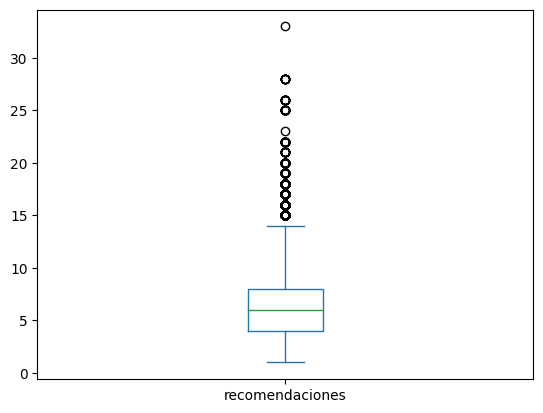

In [ ]:
df_final['recomendaciones'].plot(kind='box')

<Axes: ylabel='Frequency'>

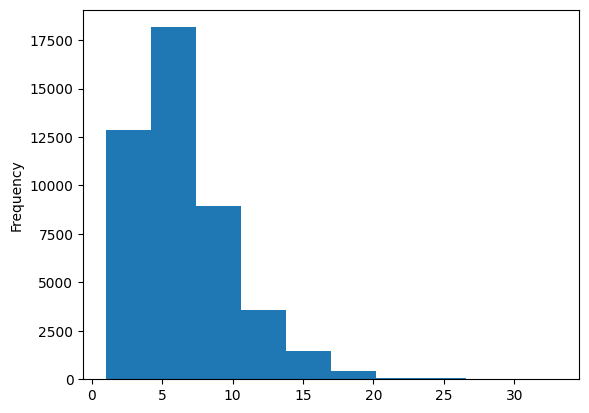

In [ ]:
df_final['recomendaciones'].plot(kind='hist')

Observando el boxplot, una alternativa sería limitar las recomendaciones a un máximo de 14. Eso haría que disminuya la cantidad de outliers y no afecten significativamente al promedio.

In [ ]:
df_final['recomendaciones'].median()

6.0

In [ ]:
df_final['recomendaciones'].mode()

0    5
Name: recomendaciones, dtype: int64

Se observa una distribución con sesgo positivo. Una recomendación de 5 o 6 productos podría ser bastante buena en función de lo que indica el histograma.

In [ ]:
df_final_modificado = df_final.copy()

In [ ]:
df_final_modificado['recomendaciones'][df_final_modificado['recomendaciones'] > 14] = 14

<Axes: ylabel='Frequency'>

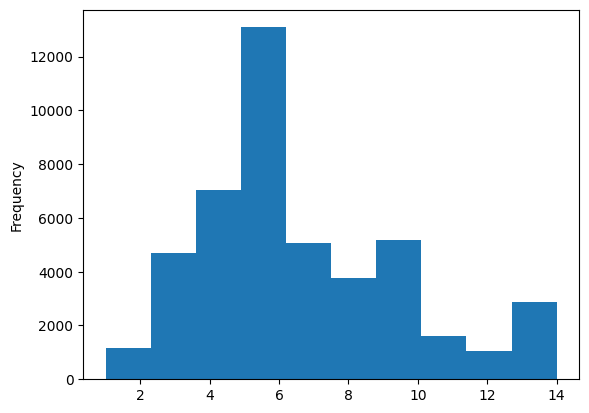

In [ ]:
df_final_modificado['recomendaciones'].plot(kind='hist')

<Axes: >

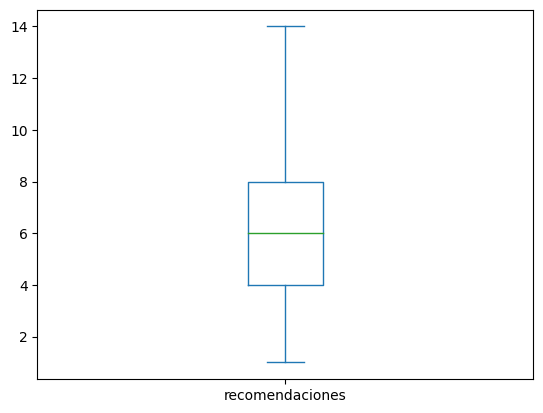

In [ ]:
df_final_modificado['recomendaciones'].plot(kind='box')

In [ ]:
df_final_modificado['recomendaciones'].describe()

count    45552.000000
mean         6.588075
std          3.009249
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         14.000000
Name: recomendaciones, dtype: float64

In [ ]:
df_final_modificado['recomendaciones'].median()

6.0

In [ ]:
df_final_modificado['recomendaciones'].mode()

0    5
Name: recomendaciones, dtype: int64

In [ ]:
usuarios  = [331490, 447520, 445654, 451882, 74764, 335995, 417866, 408145, 392364, 185697, 435069, 422935, 433942, 418056, 417100, 390305, 306713, 427863, 430210, 397435]



In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
prueba = 0
for usuario in usuarios:
    inicio_p = time.time()
    df_prueba = modelo_probabilidades(df_final_modificado, usuario, -1)
    df_pruebas = pd.concat([df_pruebas, df_prueba])
    for umbral in [0.3, 0.4, 0.5, 0.6]:
        df_prueba = modelo_estadistica(df_final_modificado, usuario, umbral)
        df_pruebas = pd.concat([df_pruebas, df_prueba])
    df_pruebas.to_excel(comparaciones + '/pruebas_nn_final_maximo_14.xlsx', index=False)
    prueba += 1
    final_p = time.time()
    sys.stdout.write(f'\rPrueba número: {prueba}   Tiempo: {round(final_p-inicio_p, 2)} segundos')
    sys.stdout.flush()
final = time.time()
print(f'Tiempo total: {final - inicio}')
df_pruebas

Prueba número: 20   Tiempo: 43.64 segundosTiempo total: 956.6931791305542


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,331490,-1.0,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[3, 48, 91, 101, 116, 154, 196, 198, 293]",9,7
0,331490,0.3,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[44, 48, 62, 116, 117, 154, 196, 198, 293]",9,6
0,331490,0.4,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[3, 44, 48, 116, 154, 181, 196, 198, 293]",9,8
0,331490,0.5,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[44, 48, 62, 116, 117, 154, 196, 198, 293]",9,6
0,331490,0.6,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[3, 44, 48, 91, 154, 181, 196, 262, 293]",9,6
...,...,...,...,...,...,...,...
0,397435,-1.0,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[8, 23, 34, 39, 41, 58, 91, 100, 152, 180, 196...",14,4
0,397435,0.3,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[23, 39, 44, 48, 62, 91, 116, 117, 147, 149, 1...",14,3
0,397435,0.4,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[6, 7, 8, 10, 23, 26, 58, 69, 91, 132, 156, 19...",18,7
0,397435,0.5,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[8, 23, 39, 44, 48, 62, 91, 116, 117, 131, 132...",14,5


In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.to_excel(comparaciones + '/pruebas_nn_final_maximo_14.xlsx', index=False)

In [ ]:
df_final_modificado['recomendaciones'][df_final_modificado['recomendaciones'] > 6] = 6

In [ ]:
usuarios  = [331490, 447520, 445654, 451882, 74764, 335995, 417866, 408145, 392364, 185697, 435069, 422935, 433942, 418056, 417100, 390305, 306713, 427863, 430210, 397435]



In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
prueba = 0
for usuario in usuarios:
    inicio_p = time.time()
    df_prueba = modelo_probabilidades(df_final_modificado, usuario, -1)
    df_pruebas = pd.concat([df_pruebas, df_prueba])
    for umbral in [0.3, 0.4, 0.5, 0.6]:
        df_prueba = modelo_estadistica(df_final_modificado, usuario, umbral)
        df_pruebas = pd.concat([df_pruebas, df_prueba])
    df_pruebas.to_excel(comparaciones + '/pruebas_nn_final_maximo_6.xlsx', index=False)
    prueba += 1
    final_p = time.time()
    sys.stdout.write(f'\rPrueba número: {prueba}   Tiempo: {round(final_p-inicio_p, 2)} segundos')
    sys.stdout.flush()
final = time.time()
print(f'Tiempo total: {final - inicio}')
df_pruebas

Prueba número: 1   Tiempo: 44.02 segundos

Prueba número: 20   Tiempo: 48.19 segundosTiempo total: 962.6207451820374


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,331490,-1.0,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 101, 116, 154, 196, 293]",6,5
0,331490,0.3,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 101, 116, 154, 196, 198, 293]",7,6
0,331490,0.4,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6
0,331490,0.5,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6
0,331490,0.6,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[44, 48, 116, 154, 196, 198]",6,5
...,...,...,...,...,...,...,...
0,397435,-1.0,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[8, 23, 39, 91, 313, 492]",6,3
0,397435,0.3,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[6, 7, 23, 39, 58, 69, 91, 131, 132, 196, 211,...",15,5
0,397435,0.4,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[23, 39, 91, 94, 100, 180, 196, 211, 313]",9,3
0,397435,0.5,"[7, 8, 26, 39, 91, 101, 132, 135, 196, 198, 29...",12,"[39, 44, 91, 196, 211, 313]",6,3


In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.to_excel(comparaciones + '/pruebas_nn_final_maximo_6.xlsx', index=False)

In [ ]:
df_pruebas.head()

,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias,accuracy,precision,recall,f1,hamming_loss
0,331490,-1.0,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 101, 116, 154, 196, 293]",6,5,0.990566,0.833333,0.555556,0.666667,0.009434
0,331490,0.3,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 101, 116, 154, 196, 198, 293]",7,6,0.992453,0.857143,0.666667,0.750000,0.007547
0,331490,0.4,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6,0.994340,1.000000,0.666667,0.800000,0.005660
0,331490,0.5,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[48, 116, 154, 196, 198, 293]",6,6,0.994340,1.000000,0.666667,0.800000,0.005660
0,331490,0.6,"[3, 48, 116, 154, 181, 196, 198, 293, 465]",9,"[44, 48, 116, 154, 196, 198]",6,5,0.990566,0.833333,0.555556,0.666667,0.009434


In [ ]:
accuracy = round(df_pruebas['accuracy'].mean()*100, 2)
precision = round(df_pruebas['precision'].mean()*100, 2)
recall = round(df_pruebas['recall'].mean()*100, 2)
f1 = round(df_pruebas['f1'].mean(), 2)
hamming_loss = round(df_pruebas['hamming_loss'].mean(), 2)
print(f'Accuracy: {accuracy}%\nPrecision: {precision}%\nRecall: {recall}%\nF1: {f1}\nHamming Loss: {hamming_loss}')

Accuracy: 98.38%
Precision: 38.61%
Recall: 31.89%
F1: 0.37
Hamming Loss: 0.02


In [ ]:
usuarios = df_final['id_usuario'].sample(100)

In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
prueba = 0
for usuario in usuarios:
    inicio_p = time.time()
    df_prueba = modelo_probabilidades(df_final_modificado, usuario, -1)
    df_pruebas = pd.concat([df_pruebas, df_prueba])
    for umbral in [0.3, 0.4, 0.5, 0.6]:
        df_prueba = modelo_estadistica(df_final_modificado, usuario, umbral)
        df_pruebas = pd.concat([df_pruebas, df_prueba])
    df_pruebas.to_excel(comparaciones + '/pruebas_nn_final_maximo_6_v2.xlsx', index=False)
    prueba += 1
    final_p = time.time()
    sys.stdout.write(f'\rPrueba número: {prueba}   Tiempo: {round(final_p-inicio_p, 2)} segundos')
    sys.stdout.flush()
final = time.time()
print(f'Tiempo total: {final - inicio}')
df_pruebas

Prueba número: 37   Tiempo: 57.51 segundos

In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.to_excel(comparaciones + '/pruebas_nn_final_maximo_6_v2.xlsx', index=False)

In [ ]:
accuracy = round(df_pruebas['accuracy'].mean()*100, 2)
precision = round(df_pruebas['precision'].mean()*100, 2)
recall = round(df_pruebas['recall'].mean()*100, 2)
f1 = round(df_pruebas['f1'].mean(), 2)
hamming_loss = round(df_pruebas['hamming_loss'].mean(), 2)
print(f'Accuracy: {accuracy}%\nPrecision: {precision}%\nRecall: {recall}%\nF1: {f1}\nHamming Loss: {hamming_loss}')

Accuracy: 98.47%
Precision: 38.38%
Recall: 42.51%
F1: 0.43
Hamming Loss: 0.02


In [ ]:
df_pruebas.groupby('umbral')['accuracy'].mean()

umbral
-1.0    0.985977
 0.3    0.985263
 0.4    0.986079
 0.5    0.981591
 0.6    0.984651
Name: accuracy, dtype: float64

In [ ]:
df_pruebas.groupby('umbral')['precision'].mean()

umbral
-1.0    0.419369
 0.3    0.371501
 0.4    0.403604
 0.5    0.377430
 0.6    0.347169
Name: precision, dtype: float64

In [ ]:
df_pruebas.groupby('umbral')['recall'].mean()

umbral
-1.0    0.435556
 0.3    0.461365
 0.4    0.440115
 0.5    0.426798
 0.6    0.361783
Name: recall, dtype: float64

In [ ]:
df_pruebas.groupby('umbral')['f1'].mean()

umbral
-1.0    0.432308
 0.3    0.447684
 0.4    0.440933
 0.5    0.431259
 0.6    0.404566
Name: f1, dtype: float64

In [ ]:
df_pruebas.groupby('umbral')['hamming_loss'].mean()

umbral
-1.0    0.014023
 0.3    0.014737
 0.4    0.013921
 0.5    0.018409
 0.6    0.015349
Name: hamming_loss, dtype: float64

#Prueba final

En líneas generales, luego de un exhaustivo análisis, se observan las mejores métricas con un umbral de entre 0.4 y 0.5 y un máximo de 6 productos, por lo que es el modelo final que usaremos. Ya descartamos embeddings, por motivos explicados previamente, y este es un modelo que tiene un rendimiento aceptable (basándonos, principalmente, en Hamming Loss) y que mejora considerablemente con el aumento de datos. Es importante aclarar que cuando hay pocos datos de un cliente y el modelo no encuentra patrones claros de compra, se agregan valores por medio de **inferencia estadística**, recomendando los productos más vendidos. Se optó por este enfoque para balancear las recomendaciones entre los beneficios para el usuario y para la empresa. Esta técnica **disminuye el rendimiento del modelo** en cuanto a las métricas, pero parece un enfoque aceptable. Para los usuarios con más datos el modelo tiene buenas métricas.

In [ ]:
usuarios = df_final['id_usuario'].sample(50)

In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
prueba = 0
for usuario in usuarios:
    inicio_p = time.time()
    df_prueba = modelo_estadistica(df_final_modificado, usuario, 0.4)
    df_pruebas = pd.concat([df_pruebas, df_prueba])
    df_pruebas.to_excel(comparaciones + '/final.xlsx', index=False)
    prueba += 1
    final_p = time.time()
    sys.stdout.write(f'\rPrueba número: {prueba}   Tiempo: {round(final_p-inicio_p, 2)} segundos')
    sys.stdout.flush()
final = time.time()
print(f'Tiempo total: {final - inicio}')
df_pruebas

Prueba número: 50   Tiempo: 9.47 segundosTiempo total: 509.5467405319214


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,424743,0.4,"[44, 48, 62, 115, 149]",5,"[44, 48, 62, 149, 389]",5,4
0,50549,0.4,[44],1,"[44, 48]",2,1
0,413032,0.4,"[141, 429, 435, 473, 477, 525]",6,"[44, 48, 62, 116, 117, 147]",6,0
0,459224,0.4,"[48, 117, 119, 154, 293, 389]",6,"[31, 48, 62, 119, 268, 293, 389, 456]",8,4
0,388045,0.4,[62],1,"[62, 149, 160, 320]",4,1
0,176379,0.4,"[18, 25, 62, 67, 149, 160, 268, 293, 301, 370]",10,"[44, 48, 62, 116, 117, 149]",6,2
0,142054,0.4,"[63, 67, 200, 349]",4,"[43, 44, 48, 67]",4,1
0,445984,0.4,"[48, 293, 389]",3,"[44, 48, 62, 116, 167, 293]",6,2
0,396169,0.4,"[3, 31, 40, 44, 48, 55, 56, 57, 59, 62, 92, 94...",17,"[26, 55, 57, 62, 92, 94, 147, 156, 157, 200]",10,7
0,181048,0.4,[62],1,"[48, 146, 200, 485]",4,0


In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.to_excel(comparaciones + '/final.xlsx', index=False)

In [ ]:
accuracy = round(df_pruebas['accuracy'].mean()*100, 2)
precision = round(df_pruebas['precision'].mean()*100, 2)
recall = round(df_pruebas['recall'].mean()*100, 2)
f1 = round(df_pruebas['f1'].mean(), 2)
hamming_loss = round(df_pruebas['hamming_loss'].mean(), 2)
print(f'Accuracy: {accuracy}%\nPrecision: {precision}%\nRecall: {recall}%\nF1: {f1}\nHamming Loss: {hamming_loss}')

Accuracy: 98.58%
Precision: 33.91%
Recall: 43.06%
F1: 0.41
Hamming Loss: 0.01


In [ ]:
df_pruebas = pd.DataFrame()
inicio = time.time()
prueba = 0
for usuario in usuarios:
    inicio_p = time.time()
    df_prueba = modelo_estadistica(df_final_modificado, usuario, 0.5)
    df_pruebas = pd.concat([df_pruebas, df_prueba])
    df_pruebas.to_excel(comparaciones + '/final_v2.xlsx', index=False)
    prueba += 1
    final_p = time.time()
    sys.stdout.write(f'\rPrueba número: {prueba}   Tiempo: {round(final_p-inicio_p, 2)} segundos')
    sys.stdout.flush()
final = time.time()
print(f'Tiempo total: {final - inicio}')
df_pruebas

Prueba número: 50   Tiempo: 10.03 segundosTiempo total: 492.73638129234314


,usuario,umbral,y_test,productos_test,y_pred,productos_pred,coincidencias
0,424743,0.5,"[44, 48, 62, 115, 149]",5,"[44, 48, 62, 116, 149]",5,4
0,50549,0.5,[44],1,"[44, 261]",2,1
0,413032,0.5,"[141, 429, 435, 473, 477, 525]",6,"[44, 48, 62, 116, 117, 147]",6,0
0,459224,0.5,"[48, 117, 119, 154, 293, 389]",6,"[44, 48, 62, 116, 117, 389]",6,3
0,388045,0.5,[62],1,"[62, 149, 160, 320]",4,1
0,176379,0.5,"[18, 25, 62, 67, 149, 160, 268, 293, 301, 370]",10,"[44, 48, 62, 116, 149, 370]",6,3
0,142054,0.5,"[63, 67, 200, 349]",4,"[43, 44, 48, 62]",4,0
0,445984,0.5,"[48, 293, 389]",3,"[44, 48, 62, 116, 117, 293]",6,2
0,396169,0.5,"[3, 31, 40, 44, 48, 55, 56, 57, 59, 62, 92, 94...",17,"[44, 48, 55, 57, 147, 157]",6,6
0,181048,0.5,[62],1,"[62, 149, 160, 320]",4,1


In [ ]:
df_pruebas['accuracy'] = (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias'])) / (df_pruebas['coincidencias'] + (530 - df_pruebas['productos_test'] - df_pruebas['productos_pred'] + df_pruebas['coincidencias']) + (df_pruebas['productos_pred'] - df_pruebas['coincidencias']) + (df_pruebas['productos_test'] - df_pruebas['coincidencias']))
df_pruebas['precision'] = df_pruebas['coincidencias'] / df_pruebas['productos_pred']
df_pruebas['recall'] = df_pruebas['coincidencias'] / df_pruebas['productos_test']
df_pruebas['f1'] = 2 * (df_pruebas['precision'] * df_pruebas['recall']) / (df_pruebas['precision'] + df_pruebas['recall'])
df_pruebas['hamming_loss'] = (df_pruebas['productos_pred'] - df_pruebas['coincidencias'] + df_pruebas['productos_test'] - df_pruebas['coincidencias']) / 530

In [ ]:
df_pruebas.to_excel(comparaciones + '/final_v2.xlsx', index=False)

In [ ]:
accuracy = round(df_pruebas['accuracy'].mean()*100, 2)
precision = round(df_pruebas['precision'].mean()*100, 2)
recall = round(df_pruebas['recall'].mean()*100, 2)
f1 = round(df_pruebas['f1'].mean(), 2)
hamming_loss = round(df_pruebas['hamming_loss'].mean(), 2)
print(f'Accuracy: {accuracy}%\nPrecision: {precision}%\nRecall: {recall}%\nF1: {f1}\nHamming Loss: {hamming_loss}')

Accuracy: 98.57%
Precision: 32.7%
Recall: 41.02%
F1: 0.38
Hamming Loss: 0.01
